# Deep Learning in Active Magnetic Regenerators

This Notebook presents the results for the application of Neural Networks in the prediction of the Cooling Capacity ($\dot{Q}_\mathrm{C}$ or $Qc$) and the Magnetization Power ($\dot{W}_\mathrm{m}$ or $Wm$) of Active Magnetic Regenerators. The Dataset consists in 532 points coming from numerical simulations.

### Importing the Modules

In [1]:
import pathlib

import joblib
import keras_tuner as kt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Activation, BatchNormalization, Dense, Dropout, Input)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam

tf.config.optimizer.set_jit(True)
mpl.style.use('default')
plt.rc('text',usetex = True)
plt.rc('font', family='serif',size = 12)

### Plotting Functions 

In [2]:
def plot_results(y_train,y_pred_train,y_test,y_pred_test,Obj):
    
    plt.figure()
    plt.plot(y_train,y_pred_train,'.',markersize = 7,color = '#1f77b4', mfc='none', label = 'Training Set')
    plt.plot(y_test,y_pred_test,'x' ,markersize = 5, color = '#2ca02c', mfc='none',label = 'Test Set',)
    
    if Obj == 'Qc [W]':
        Aux = np.linspace(0,80)
        plt.plot(Aux,0.9*Aux,'k--')
        plt.plot(Aux,1.1*Aux,'k--')
        plt.text(40, 60, '$+ 10 \%$', fontsize=12)
        plt.text(50, 30, '$- 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{Q}_\mathrm{C}$ [W] - ANN' )
        plt.xlabel(r' $\dot{Q}_\mathrm{C}$ [W] - Experimental')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Qc/Qc - NN.png', format = 'png', bbox_inches='tight') 
    
    elif Obj == 'Wm':
        Aux = np.linspace(10,60)
        plt.plot(Aux,0.95*Aux,'k--')
        plt.plot(Aux,1.05*Aux,'k--')
        plt.text(23, 17, '$- 10 \%$', fontsize=12)
        plt.text(19, 28, '$+ 10 \%$', fontsize=12)
        plt.legend()
        plt.ylabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - ANN' )
        plt.xlabel(r' $\dot{W}_\mathrm{AMR,mag}$ [W] - Experimental')
        plt.grid(linestyle='dotted')
        plt.savefig('Plots/Wm/Wm - NN.png', format = 'png', bbox_inches='tight') 

### Reading the Input Parameteres 

The independent variable are the Width ($H$), Height ($H$) and Length ($L$) of the porous medium, the frequency ($f$) and mass flow rate ($mf$) of the Active Magnetic Regenerator, the Inlet Temperatures at the Hot ($Th$) and Cold ($Tc$) ends and the Applied Magnetic Field ($B$).

The dependent variables are the Cooling Capacity ($Qc$) and Magnetization Power ($Wm$).

In [3]:
Inputs = pd.read_excel('Data/Data_AMR_Exp.xlsx',index_col = 0) # Input Data
X = Inputs[Inputs.columns[:-4]]
y = Inputs[['Qc [W]']]

### Train-Test Split

In [4]:
Qc_min = -2

In [30]:
#X = X[(y['Qc [W]'] > Qc_min) & (X['Test'] != 'MCR') & (X['Tspan [K]'] > 0)]
#y = y[(y['Qc [W]'] > Qc_min) & (X['Test'] != 'MCR') & (X['Tspan [K]'] > 0)]

In [5]:
X = X[(y['Qc [W]'] >= Qc_min) & (X['Tspan [K]'] >= -1)]
y = y[(y['Qc [W]'] >= Qc_min) & (X['Tspan [K]'] >= -1)]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    stratify = X['Test'],
                                                    random_state = 42)
X_train = X_train.drop(['Test'],axis = 1)
X_test = X_test.drop(['Test'],axis = 1)

### Scaling the Features

In [7]:
#sc = joblib.load('Models/AMR_Scaler.pkl')
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
joblib.dump(sc, 'Models/AMR_Scaler.pkl') 

['Models/AMR_Scaler.pkl']

### Building the Model

In [10]:
def Build(hp):
    
    
    #Grouping a stack of Layers in Model
    model = tf.keras.Sequential()
    model.add(BatchNormalization())

    #Kernel Initialization
    initializer = tf.keras.initializers.HeNormal()

    # Adding the Layers
    # The number of layers, neurons in each one and activation functions are going to be tunned 
    
    hp_l1_reg = hp.Choice('l1_reg', values=[1e-8, 1e-9, 1e-10, 1e-11, 0.0])
    hp_l2_reg = hp.Choice('l2_reg', values=[1e-8, 1e-9, 1e-10, 1e-11, 0.0])
    
    for i in range(hp.Int('layers', 0, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 1, 201, step=2),
                                        activation=hp.Choice('act_' + str(i), ['relu','sigmoid','selu','tanh', 'softmax','elu']),
                                        kernel_initializer = initializer,
                                        kernel_regularizer=regularizers.L1L2(l1= hp_l1_reg, l2=hp_l2_reg)
                                        )
        )

        #model.add(Dropout(0.4))
        model.add(Dropout(rate = hp.Choice('dropout_rate', values=[0.0, 0.05, 0.1, 0.15])))
        #Applying a Batch Normalization Layer after Dense Layer
        model.add(BatchNormalization())

        
    # Adding a final Layer 
    model.add(tf.keras.layers.Dense(1, 
                                    activation=hp.Choice('act_output', ['relu','sigmoid','selu','tanh', 'softmax','elu']),
                                    kernel_initializer = initializer
                                   )
             )
    
    
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3])
    hp_epsilon = hp.Choice('epsilon', values=[1e-6, 1e-7, 1e8])
    hp_weightdecay = hp.Choice('weight_decay', values = [1e-5, 1e-6, 1e-7, 0.0])
    
    # Compiling the Model with the Adam optimization algorithm
    model.compile(optimizer=Adam(learning_rate = hp_learning_rate
                                 , epsilon = hp_epsilon
                                 , weight_decay = hp_weightdecay
                                ),
                            loss="mean_squared_error",
                            metrics = ['accuracy']
                            )
    return model

### Batch Optimization

Overriding run_trial in MyTuner (https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d)

In [34]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 20, 501, step=5)
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 1000, 5000, step = 100)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

### Defining the Tuner

In [35]:
def NeuNet(X_train,y_train,max_epochs,Obj):
    
    # Defining the Tuner
    tuner = MyTuner(Build,
                    objective = 'val_loss',
                    #max_epochs = max_epochs,
                    directory= 'KT_Dir',
                    project_name='KT_Hyperband_epochs_new_finer',
                    executions_per_trial = 1,   
    )
    
    # Hyperparameter Optimization
    tuner.search(X_train,
                 y_train[Obj],
                 epochs=max_epochs,
                 callbacks=[EarlyStopping('val_loss', patience=10)],
                 verbose=1,
                 validation_split=0.2)
    
  
    # Trainning the Best Model
    best_model = tuner.get_best_models()[0]
    best_model.build(X_train.shape)
    best_model.fit(X_train,
                   y_train[Obj], 
                   epochs=max_epochs,
                   batch_size=tuner.get_best_hyperparameters(num_trials=1)[0].get('batch_size')
    )
    best_model.summary()
    
    best_hyp = tuner.get_best_hyperparameters()[0]
    
    print('\n The hyperparameters of the model are' + str(best_hyp.values) + '\n')
    
    # Saving the Model
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN.h5', include_optimizer=False)
    best_model.save('Models/'+Obj+'/'+ Obj +'_NN', include_optimizer=False)
    best_model.save_weights('Models/'+Obj+'/'+ Obj +'_weights.h5')
    #joblib.dump(best_model, 'Models/'+Obj+'/'+ Obj +'_NN.pkl')
    
     #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], best_model.predict(X_train))) + '\n')

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], best_model.predict(X_test))) + '\n') 

    # Plotting the Results
    plot_results(y_train[Obj], best_model.predict(X_train), y_test[Obj], best_model.predict(X_test), Obj) 

### Defining a Test Function

In [36]:
def Test(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()


    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
            
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test))))) 

    # Plotting the Results
    plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

In [37]:
def Test_lite(X_train,y_train,Obj, Scal):
    
    Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
    Model.summary()
    for i, layer in enumerate (Model.layers):
        print (i, layer)
        try:
            print ("    ",layer.activation)
        except AttributeError:
            print('   no activation attribute')
    converter = tf.lite.TFLiteConverter.from_keras_model(Model)
    tflite_model = converter.convert()
    tflite_models_dir = pathlib.Path("/")
    tflite_models_dir.mkdir(exist_ok=True, parents=True)
    tflite_model_file = tflite_models_dir/"mnist_model.tflite"
    tflite_model_file.write_bytes(tflite_model)
    
    interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    Train_Lite = []
    for i in range(np.shape(X_train)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_train)[i].reshape(-1,1).T)
        interpreter.invoke()
        Train_Lite.append(interpreter.get_tensor(output_index)[0][0])
        
    Test_Lite = []
    for i in range(np.shape(X_test)[0]):
        interpreter.set_tensor(input_index, Scaller.transform(X_test)[i].reshape(-1,1).T)
        interpreter.invoke()
        Test_Lite.append(interpreter.get_tensor(output_index)[0][0])
    
    #R2 for the Training Set
    print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
          str(r2_score(y_train[Obj], Train_Lite)))

    # R2 for the Test Set
    print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
          str(r2_score(y_test[Obj], Test_Lite)))    
    
    # Plotting the Results
    plot_results(y_train[Obj], Train_Lite, y_test[Obj], Test_Lite, Obj) 

### Training the Models

Trial 254 Complete [00h 00m 12s]
val_loss: 262.4920349121094

Best val_loss So Far: 12.212627410888672
Total elapsed time: 00h 12m 18s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5000
6/6 [==============================] - 1s 3ms/step - loss: 23.1385 - accuracy: 0.0273
Epoch 2/5000
6/6 [==============================] - 0s 3ms/step - loss: 19.6556 - accuracy: 0.0378
Epoch 3/5000
6/6 [==============================] - 0s 2ms/step - loss: 16.9911 - accuracy: 0.0357
Epoch 4/5000
6/6 [==============================] - 0s 3ms/step - loss: 19.4508 - accuracy: 0.0336
Epoch 5/5000
6/6 [==============================] - 0s 3ms/step - loss: 16.7341 - accuracy: 0.0336
Epoch 6/5000
6/6 [==============================] - 0s 3ms/step - loss: 16.8507 - accuracy: 0.0378
Epoch 7/5000
6/6 [==============================] - 0s 3ms/step - loss: 15.7340 - accuracy: 0.0336
Epoch 8/5000
6/6 [==============================] - 0s 3ms/step - loss: 15.8303 - accuracy: 0.0399
Epoch 9/5000
6/6 [=================

6/6 [==============================] - 0s 4ms/step - loss: 12.3068 - accuracy: 0.0378
Epoch 82/5000
6/6 [==============================] - 0s 4ms/step - loss: 10.5327 - accuracy: 0.0252
Epoch 83/5000
6/6 [==============================] - 0s 4ms/step - loss: 12.1151 - accuracy: 0.0378
Epoch 84/5000
6/6 [==============================] - 0s 4ms/step - loss: 9.4515 - accuracy: 0.0378
Epoch 85/5000
6/6 [==============================] - 0s 4ms/step - loss: 10.6619 - accuracy: 0.0252
Epoch 86/5000
6/6 [==============================] - 0s 4ms/step - loss: 10.0193 - accuracy: 0.0315
Epoch 87/5000
6/6 [==============================] - 0s 4ms/step - loss: 7.7993 - accuracy: 0.0357
Epoch 88/5000
6/6 [==============================] - 0s 4ms/step - loss: 10.6542 - accuracy: 0.0357
Epoch 89/5000
6/6 [==============================] - 0s 4ms/step - loss: 11.1167 - accuracy: 0.0315
Epoch 90/5000
6/6 [==============================] - 0s 4ms/step - loss: 9.3639 - accuracy: 0.0336
Epoch 91/5000
6/6

6/6 [==============================] - 0s 3ms/step - loss: 11.7836 - accuracy: 0.0336
Epoch 163/5000
6/6 [==============================] - 0s 2ms/step - loss: 10.8960 - accuracy: 0.0357
Epoch 164/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2688 - accuracy: 0.0336
Epoch 165/5000
6/6 [==============================] - 0s 3ms/step - loss: 12.3801 - accuracy: 0.0294
Epoch 166/5000
6/6 [==============================] - 0s 3ms/step - loss: 11.3187 - accuracy: 0.0378
Epoch 167/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.6066 - accuracy: 0.0336
Epoch 168/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.0721 - accuracy: 0.0336
Epoch 169/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.1774 - accuracy: 0.0357
Epoch 170/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.6947 - accuracy: 0.0273
Epoch 171/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.4190 - accuracy: 0.0357
Epoch 172

6/6 [==============================] - 0s 2ms/step - loss: 13.1004 - accuracy: 0.0315
Epoch 244/5000
6/6 [==============================] - 0s 3ms/step - loss: 12.4723 - accuracy: 0.0357
Epoch 245/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.6702 - accuracy: 0.0294
Epoch 246/5000
6/6 [==============================] - 0s 3ms/step - loss: 11.8074 - accuracy: 0.0252
Epoch 247/5000
6/6 [==============================] - 0s 2ms/step - loss: 13.2995 - accuracy: 0.0189
Epoch 248/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.0362 - accuracy: 0.0315
Epoch 249/5000
6/6 [==============================] - 0s 3ms/step - loss: 11.9678 - accuracy: 0.0336
Epoch 250/5000
6/6 [==============================] - 0s 3ms/step - loss: 11.8901 - accuracy: 0.0252
Epoch 251/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.3002 - accuracy: 0.0210
Epoch 252/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.5838 - accuracy: 0.0210 
Epoch 2

6/6 [==============================] - 0s 2ms/step - loss: 9.1404 - accuracy: 0.0378
Epoch 325/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.5069 - accuracy: 0.0336
Epoch 326/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.9983 - accuracy: 0.0336
Epoch 327/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.4642 - accuracy: 0.0294
Epoch 328/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.9712 - accuracy: 0.0336
Epoch 329/5000
6/6 [==============================] - 0s 4ms/step - loss: 8.6684 - accuracy: 0.0231
Epoch 330/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.4748 - accuracy: 0.0252
Epoch 331/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.5426 - accuracy: 0.0231
Epoch 332/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0992 - accuracy: 0.0273
Epoch 333/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.0475 - accuracy: 0.0252
Epoch 334/5000


Epoch 406/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.7082 - accuracy: 0.0294
Epoch 407/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3311 - accuracy: 0.0294
Epoch 408/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.7813 - accuracy: 0.0336
Epoch 409/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.3151 - accuracy: 0.0336
Epoch 410/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.0101 - accuracy: 0.0315
Epoch 411/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.8592 - accuracy: 0.0336
Epoch 412/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.5185 - accuracy: 0.0315
Epoch 413/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.6358 - accuracy: 0.0294
Epoch 414/5000
6/6 [==============================] - 0s 3ms/step - loss: 11.1396 - accuracy: 0.0336
Epoch 415/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7824 - accuracy: 0.03

6/6 [==============================] - 0s 3ms/step - loss: 7.0428 - accuracy: 0.0357
Epoch 488/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.9624 - accuracy: 0.0294
Epoch 489/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3082 - accuracy: 0.0294
Epoch 490/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.4708 - accuracy: 0.0273
Epoch 491/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.3691 - accuracy: 0.0231
Epoch 492/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.9448 - accuracy: 0.0294
Epoch 493/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2567 - accuracy: 0.0399
Epoch 494/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.0479 - accuracy: 0.0336
Epoch 495/5000
6/6 [==============================] - 0s 2ms/step - loss: 10.7160 - accuracy: 0.0336
Epoch 496/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.2136 - accuracy: 0.0210
Epoch 497/500

6/6 [==============================] - 0s 3ms/step - loss: 7.7697 - accuracy: 0.0336
Epoch 570/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.1131 - accuracy: 0.0336
Epoch 571/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.9774 - accuracy: 0.0315
Epoch 572/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.5145 - accuracy: 0.0357
Epoch 573/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.8406 - accuracy: 0.0273
Epoch 574/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.2703 - accuracy: 0.0315
Epoch 575/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.4206 - accuracy: 0.0273
Epoch 576/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7546 - accuracy: 0.0273
Epoch 577/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.8687 - accuracy: 0.0252
Epoch 578/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4574 - accuracy: 0.0294
Epoch 579/5000


6/6 [==============================] - 0s 3ms/step - loss: 6.7970 - accuracy: 0.0294
Epoch 652/5000
6/6 [==============================] - 0s 2ms/step - loss: 10.4191 - accuracy: 0.0273
Epoch 653/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3494 - accuracy: 0.0168
Epoch 654/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.8184 - accuracy: 0.0210
Epoch 655/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.5077 - accuracy: 0.0231
Epoch 656/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.7651 - accuracy: 0.0315
Epoch 657/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0190 - accuracy: 0.0273
Epoch 658/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5298 - accuracy: 0.0252
Epoch 659/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.6761 - accuracy: 0.0315
Epoch 660/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1213 - accuracy: 0.0252
Epoch 661/5000

6/6 [==============================] - 0s 3ms/step - loss: 7.7653 - accuracy: 0.0357
Epoch 734/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0762 - accuracy: 0.0273
Epoch 735/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6231 - accuracy: 0.0294
Epoch 736/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.6992 - accuracy: 0.0357
Epoch 737/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7623 - accuracy: 0.0315
Epoch 738/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5116 - accuracy: 0.0273
Epoch 739/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.3363 - accuracy: 0.0231
Epoch 740/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2057 - accuracy: 0.0315 
Epoch 741/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.5744 - accuracy: 0.0294
Epoch 742/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3325 - accuracy: 0.0231
Epoch 743/5000

6/6 [==============================] - 0s 2ms/step - loss: 7.1612 - accuracy: 0.0399
Epoch 816/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7303 - accuracy: 0.0336
Epoch 817/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.8771 - accuracy: 0.0294
Epoch 818/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.1231 - accuracy: 0.0273
Epoch 819/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4080 - accuracy: 0.0252
Epoch 820/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.0657 - accuracy: 0.0336
Epoch 821/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.8377 - accuracy: 0.0252
Epoch 822/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.9272 - accuracy: 0.0315
Epoch 823/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.5606 - accuracy: 0.0294
Epoch 824/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.4990 - accuracy: 0.0294
Epoch 825/5000


6/6 [==============================] - 0s 3ms/step - loss: 7.3053 - accuracy: 0.0315
Epoch 898/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.0981 - accuracy: 0.0252
Epoch 899/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.4003 - accuracy: 0.0273
Epoch 900/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.8461 - accuracy: 0.0252
Epoch 901/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2213 - accuracy: 0.0336
Epoch 902/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.4806 - accuracy: 0.0294
Epoch 903/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.5452 - accuracy: 0.0252
Epoch 904/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7359 - accuracy: 0.0294
Epoch 905/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.8291 - accuracy: 0.0294
Epoch 906/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0842 - accuracy: 0.0336
Epoch 907/5000


6/6 [==============================] - 0s 3ms/step - loss: 6.1874 - accuracy: 0.0231
Epoch 980/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4237 - accuracy: 0.0294
Epoch 981/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2949 - accuracy: 0.0273
Epoch 982/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.7760 - accuracy: 0.0357
Epoch 983/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.0777 - accuracy: 0.0252
Epoch 984/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4951 - accuracy: 0.0378
Epoch 985/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.6167 - accuracy: 0.0294
Epoch 986/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3511 - accuracy: 0.0252
Epoch 987/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1726 - accuracy: 0.0315
Epoch 988/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1951 - accuracy: 0.0273
Epoch 989/5000


6/6 [==============================] - 0s 3ms/step - loss: 5.6831 - accuracy: 0.0378
Epoch 1061/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5173 - accuracy: 0.0294
Epoch 1062/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8627 - accuracy: 0.0315
Epoch 1063/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8011 - accuracy: 0.0315
Epoch 1064/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2084 - accuracy: 0.0336
Epoch 1065/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9003 - accuracy: 0.0210
Epoch 1066/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.3518 - accuracy: 0.0273
Epoch 1067/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1698 - accuracy: 0.0315
Epoch 1068/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9710 - accuracy: 0.0336
Epoch 1069/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.8519 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 6.0825 - accuracy: 0.0357
Epoch 1142/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3336 - accuracy: 0.0273
Epoch 1143/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8531 - accuracy: 0.0294
Epoch 1144/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.3380 - accuracy: 0.0273
Epoch 1145/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.0423 - accuracy: 0.0273
Epoch 1146/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2381 - accuracy: 0.0315
Epoch 1147/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.5964 - accuracy: 0.0315
Epoch 1148/5000
6/6 [==============================] - 0s 2ms/step - loss: 10.1568 - accuracy: 0.0294
Epoch 1149/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6314 - accuracy: 0.0336
Epoch 1150/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8202 - accuracy: 0.0357
Epoch

6/6 [==============================] - 0s 3ms/step - loss: 6.5006 - accuracy: 0.0273
Epoch 1223/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4980 - accuracy: 0.0294
Epoch 1224/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7148 - accuracy: 0.0294
Epoch 1225/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.7238 - accuracy: 0.0336
Epoch 1226/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.1152 - accuracy: 0.0294
Epoch 1227/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.4396 - accuracy: 0.0315
Epoch 1228/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.4839 - accuracy: 0.0399
Epoch 1229/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7412 - accuracy: 0.0315
Epoch 1230/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2576 - accuracy: 0.0294
Epoch 1231/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.3930 - accuracy: 0.0336
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 7.8907 - accuracy: 0.0315
Epoch 1304/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.6176 - accuracy: 0.0273
Epoch 1305/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.3130 - accuracy: 0.0357
Epoch 1306/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1330 - accuracy: 0.0378
Epoch 1307/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.1948 - accuracy: 0.0336
Epoch 1308/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6861 - accuracy: 0.0378
Epoch 1309/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5781 - accuracy: 0.0273
Epoch 1310/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9225 - accuracy: 0.0273
Epoch 1311/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3914 - accuracy: 0.0294
Epoch 1312/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2847 - accuracy: 0.0336
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.1246 - accuracy: 0.0336
Epoch 1385/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.7574 - accuracy: 0.0294
Epoch 1386/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.8723 - accuracy: 0.0273
Epoch 1387/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.5728 - accuracy: 0.0315
Epoch 1388/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4409 - accuracy: 0.0357
Epoch 1389/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6292 - accuracy: 0.0378
Epoch 1390/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.1695 - accuracy: 0.0273
Epoch 1391/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.0867 - accuracy: 0.0273
Epoch 1392/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0130 - accuracy: 0.0294
Epoch 1393/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3242 - accuracy: 0.0294
Epoch

6/6 [==============================] - 0s 3ms/step - loss: 12.6429 - accuracy: 0.0147
Epoch 1466/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7849 - accuracy: 0.0252
Epoch 1467/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.0552 - accuracy: 0.0273
Epoch 1468/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.7295 - accuracy: 0.0273
Epoch 1469/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1821 - accuracy: 0.0315
Epoch 1470/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.8716 - accuracy: 0.0315
Epoch 1471/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7950 - accuracy: 0.0273
Epoch 1472/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0713 - accuracy: 0.0315
Epoch 1473/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3035 - accuracy: 0.0294
Epoch 1474/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3992 - accuracy: 0.0273
Epoch

6/6 [==============================] - 0s 2ms/step - loss: 5.7030 - accuracy: 0.0336
Epoch 1547/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8004 - accuracy: 0.0294
Epoch 1548/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9664 - accuracy: 0.0231
Epoch 1549/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6679 - accuracy: 0.0294
Epoch 1550/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.1335 - accuracy: 0.0273
Epoch 1551/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8945 - accuracy: 0.0378
Epoch 1552/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3671 - accuracy: 0.0336
Epoch 1553/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.6305 - accuracy: 0.0273
Epoch 1554/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.5379 - accuracy: 0.0252
Epoch 1555/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1723 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 8.0312 - accuracy: 0.0336
Epoch 1628/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.3383 - accuracy: 0.0315
Epoch 1629/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0407 - accuracy: 0.0315
Epoch 1630/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2828 - accuracy: 0.0273
Epoch 1631/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1734 - accuracy: 0.0252
Epoch 1632/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.8779 - accuracy: 0.0336
Epoch 1633/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6838 - accuracy: 0.0273
Epoch 1634/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.9269 - accuracy: 0.0357
Epoch 1635/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4627 - accuracy: 0.0294
Epoch 1636/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5272 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.8821 - accuracy: 0.0273
Epoch 1709/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1680 - accuracy: 0.0189
Epoch 1710/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4033 - accuracy: 0.0336
Epoch 1711/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1848 - accuracy: 0.0252
Epoch 1712/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2393 - accuracy: 0.0273
Epoch 1713/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6758 - accuracy: 0.0294
Epoch 1714/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.0267 - accuracy: 0.0294
Epoch 1715/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6521 - accuracy: 0.0294
Epoch 1716/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.9877 - accuracy: 0.0273
Epoch 1717/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2764 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 7.0060 - accuracy: 0.0294
Epoch 1790/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3853 - accuracy: 0.0315
Epoch 1791/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3345 - accuracy: 0.0273
Epoch 1792/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2863 - accuracy: 0.0315
Epoch 1793/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.9180 - accuracy: 0.0252
Epoch 1794/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2134 - accuracy: 0.0252
Epoch 1795/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3758 - accuracy: 0.0294
Epoch 1796/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.3537 - accuracy: 0.0252
Epoch 1797/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.0270 - accuracy: 0.0315
Epoch 1798/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.9641 - accuracy: 0.0252
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 6.0580 - accuracy: 0.0315
Epoch 1871/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.4474 - accuracy: 0.0336
Epoch 1872/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.0350 - accuracy: 0.0294
Epoch 1873/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0433 - accuracy: 0.0294
Epoch 1874/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.2263 - accuracy: 0.0231
Epoch 1875/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.3941 - accuracy: 0.0294
Epoch 1876/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.5619 - accuracy: 0.0315
Epoch 1877/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.5625 - accuracy: 0.0378
Epoch 1878/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3582 - accuracy: 0.0315
Epoch 1879/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.9155 - accuracy: 0.0189
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 8.2696 - accuracy: 0.0294
Epoch 1952/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.5050 - accuracy: 0.0231
Epoch 1953/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4285 - accuracy: 0.0252
Epoch 1954/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0484 - accuracy: 0.0210
Epoch 1955/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0882 - accuracy: 0.0336
Epoch 1956/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3929 - accuracy: 0.0336
Epoch 1957/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1988 - accuracy: 0.0189
Epoch 1958/5000
6/6 [==============================] - 0s 4ms/step - loss: 7.9672 - accuracy: 0.0336
Epoch 1959/5000
6/6 [==============================] - 0s 4ms/step - loss: 7.7007 - accuracy: 0.0273
Epoch 1960/5000
6/6 [==============================] - 0s 4ms/step - loss: 6.0135 - accuracy: 0.0231
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 11.9602 - accuracy: 0.0357
Epoch 2033/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2834 - accuracy: 0.0357
Epoch 2034/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.7234 - accuracy: 0.0357
Epoch 2035/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8316 - accuracy: 0.0294
Epoch 2036/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.9052 - accuracy: 0.0231
Epoch 2037/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0099 - accuracy: 0.0336
Epoch 2038/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1301 - accuracy: 0.0336
Epoch 2039/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1590 - accuracy: 0.0315
Epoch 2040/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3477 - accuracy: 0.0315
Epoch 2041/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2551 - accuracy: 0.0252 
Epoc

6/6 [==============================] - 0s 3ms/step - loss: 5.7375 - accuracy: 0.0315
Epoch 2114/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6010 - accuracy: 0.0378
Epoch 2115/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4217 - accuracy: 0.0231
Epoch 2116/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3163 - accuracy: 0.0315
Epoch 2117/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7721 - accuracy: 0.0378
Epoch 2118/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4597 - accuracy: 0.0210
Epoch 2119/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5888 - accuracy: 0.0315
Epoch 2120/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2284 - accuracy: 0.0231
Epoch 2121/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1699 - accuracy: 0.0315
Epoch 2122/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3144 - accuracy: 0.0336
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.4744 - accuracy: 0.0273
Epoch 2195/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1381 - accuracy: 0.0315
Epoch 2196/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.8941 - accuracy: 0.0315
Epoch 2197/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5505 - accuracy: 0.0273
Epoch 2198/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0876 - accuracy: 0.0273
Epoch 2199/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.4770 - accuracy: 0.0294
Epoch 2200/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.8856 - accuracy: 0.0294
Epoch 2201/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2174 - accuracy: 0.0357
Epoch 2202/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.4644 - accuracy: 0.0336
Epoch 2203/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.5837 - accuracy: 0.0252
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 8.5343 - accuracy: 0.0336
Epoch 2276/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.5120 - accuracy: 0.0294
Epoch 2277/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8230 - accuracy: 0.0294
Epoch 2278/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4663 - accuracy: 0.0336
Epoch 2279/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5190 - accuracy: 0.0336
Epoch 2280/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5423 - accuracy: 0.0357
Epoch 2281/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.4168 - accuracy: 0.0294
Epoch 2282/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.3810 - accuracy: 0.0273
Epoch 2283/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1851 - accuracy: 0.0294
Epoch 2284/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2700 - accuracy: 0.0273
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 4.9514 - accuracy: 0.0273
Epoch 2357/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2886 - accuracy: 0.0315
Epoch 2358/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.8902 - accuracy: 0.0336
Epoch 2359/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.9341 - accuracy: 0.0231
Epoch 2360/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.9522 - accuracy: 0.0210
Epoch 2361/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3035 - accuracy: 0.0357
Epoch 2362/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3294 - accuracy: 0.0252
Epoch 2363/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.1514 - accuracy: 0.0189
Epoch 2364/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5551 - accuracy: 0.0210
Epoch 2365/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4189 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 7.3280 - accuracy: 0.0252
Epoch 2438/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.5227 - accuracy: 0.0210
Epoch 2439/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.2469 - accuracy: 0.0315
Epoch 2440/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4161 - accuracy: 0.0231
Epoch 2441/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9715 - accuracy: 0.0294
Epoch 2442/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0096 - accuracy: 0.0294
Epoch 2443/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.3293 - accuracy: 0.0210
Epoch 2444/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4634 - accuracy: 0.0273
Epoch 2445/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.8205 - accuracy: 0.0315
Epoch 2446/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.6430 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 6.4372 - accuracy: 0.0252
Epoch 2519/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.1989 - accuracy: 0.0273
Epoch 2520/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.4923 - accuracy: 0.0231
Epoch 2521/5000
6/6 [==============================] - 0s 2ms/step - loss: 4.7548 - accuracy: 0.0315
Epoch 2522/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.0486 - accuracy: 0.0273
Epoch 2523/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2186 - accuracy: 0.0315
Epoch 2524/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2670 - accuracy: 0.0336
Epoch 2525/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1603 - accuracy: 0.0315
Epoch 2526/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.1360 - accuracy: 0.0315
Epoch 2527/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.7152 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 4.7297 - accuracy: 0.0315
Epoch 2600/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8484 - accuracy: 0.0315
Epoch 2601/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7958 - accuracy: 0.0315
Epoch 2602/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6317 - accuracy: 0.0357
Epoch 2603/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1474 - accuracy: 0.0315
Epoch 2604/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2995 - accuracy: 0.0294
Epoch 2605/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.1516 - accuracy: 0.0357
Epoch 2606/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.9033 - accuracy: 0.0315
Epoch 2607/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.2694 - accuracy: 0.0315
Epoch 2608/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9824 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.5617 - accuracy: 0.0336
Epoch 2681/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7628 - accuracy: 0.0210
Epoch 2682/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7823 - accuracy: 0.0273
Epoch 2683/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9085 - accuracy: 0.0294
Epoch 2684/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3957 - accuracy: 0.0294
Epoch 2685/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.8306 - accuracy: 0.0336
Epoch 2686/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5270 - accuracy: 0.0336
Epoch 2687/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5531 - accuracy: 0.0273
Epoch 2688/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.0290 - accuracy: 0.0315
Epoch 2689/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7060 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 7.5078 - accuracy: 0.0378
Epoch 2762/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4723 - accuracy: 0.0357
Epoch 2763/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5213 - accuracy: 0.0315
Epoch 2764/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1459 - accuracy: 0.0336
Epoch 2765/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9438 - accuracy: 0.0336
Epoch 2766/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.9706 - accuracy: 0.0315
Epoch 2767/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1384 - accuracy: 0.0273
Epoch 2768/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4274 - accuracy: 0.0315
Epoch 2769/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0968 - accuracy: 0.0357
Epoch 2770/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1017 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.4695 - accuracy: 0.0315
Epoch 2843/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7902 - accuracy: 0.0231
Epoch 2844/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.3628 - accuracy: 0.0231
Epoch 2845/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.6784 - accuracy: 0.0294
Epoch 2846/5000
6/6 [==============================] - 0s 2ms/step - loss: 9.3538 - accuracy: 0.0231
Epoch 2847/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.0636 - accuracy: 0.0252
Epoch 2848/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.3705 - accuracy: 0.0273
Epoch 2849/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.0769 - accuracy: 0.0294
Epoch 2850/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.2921 - accuracy: 0.0252
Epoch 2851/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.3189 - accuracy: 0.0210
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.1911 - accuracy: 0.0273
Epoch 2924/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0970 - accuracy: 0.0315
Epoch 2925/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9593 - accuracy: 0.0336
Epoch 2926/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.9242 - accuracy: 0.0315
Epoch 2927/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6174 - accuracy: 0.0378
Epoch 2928/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5113 - accuracy: 0.0336
Epoch 2929/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8120 - accuracy: 0.0315
Epoch 2930/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4831 - accuracy: 0.0315
Epoch 2931/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.8834 - accuracy: 0.0315
Epoch 2932/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.8954 - accuracy: 0.0273
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 7.7796 - accuracy: 0.0315
Epoch 3005/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.4021 - accuracy: 0.0336
Epoch 3006/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.3351 - accuracy: 0.0336
Epoch 3007/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.4722 - accuracy: 0.0231
Epoch 3008/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.7438 - accuracy: 0.0273
Epoch 3009/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.2680 - accuracy: 0.0315
Epoch 3010/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.1766 - accuracy: 0.0357
Epoch 3011/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7318 - accuracy: 0.0315
Epoch 3012/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0470 - accuracy: 0.0315
Epoch 3013/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8005 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 7.0594 - accuracy: 0.0210
Epoch 3086/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7845 - accuracy: 0.0357
Epoch 3087/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.2344 - accuracy: 0.0294
Epoch 3088/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4358 - accuracy: 0.0357
Epoch 3089/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3799 - accuracy: 0.0378
Epoch 3090/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0248 - accuracy: 0.0378
Epoch 3091/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.7677 - accuracy: 0.0357
Epoch 3092/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3651 - accuracy: 0.0273
Epoch 3093/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.1011 - accuracy: 0.0315
Epoch 3094/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.4385 - accuracy: 0.0378
Epoch

6/6 [==============================] - 0s 2ms/step - loss: 10.3204 - accuracy: 0.0189
Epoch 3167/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.9279 - accuracy: 0.0252
Epoch 3168/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.0963 - accuracy: 0.0336
Epoch 3169/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2479 - accuracy: 0.0252
Epoch 3170/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.5490 - accuracy: 0.0294
Epoch 3171/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0082 - accuracy: 0.0336
Epoch 3172/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0319 - accuracy: 0.0252
Epoch 3173/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8156 - accuracy: 0.0252
Epoch 3174/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6397 - accuracy: 0.0315
Epoch 3175/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7198 - accuracy: 0.0294
Epoch

6/6 [==============================] - 0s 3ms/step - loss: 10.1159 - accuracy: 0.0273
Epoch 3248/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4467 - accuracy: 0.0231
Epoch 3249/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.8459 - accuracy: 0.0273
Epoch 3250/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0826 - accuracy: 0.0273
Epoch 3251/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1261 - accuracy: 0.0315
Epoch 3252/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.0577 - accuracy: 0.0315
Epoch 3253/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.2738 - accuracy: 0.0336
Epoch 3254/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7374 - accuracy: 0.0357
Epoch 3255/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9928 - accuracy: 0.0252
Epoch 3256/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8941 - accuracy: 0.0273
Epoch

6/6 [==============================] - 0s 2ms/step - loss: 6.8124 - accuracy: 0.0315
Epoch 3329/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5602 - accuracy: 0.0399
Epoch 3330/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1014 - accuracy: 0.0357
Epoch 3331/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0292 - accuracy: 0.0357
Epoch 3332/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5130 - accuracy: 0.0357
Epoch 3333/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7629 - accuracy: 0.0315
Epoch 3334/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4330 - accuracy: 0.0273
Epoch 3335/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.1857 - accuracy: 0.0294
Epoch 3336/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4520 - accuracy: 0.0315
Epoch 3337/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9527 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 5.5344 - accuracy: 0.0357
Epoch 3410/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8925 - accuracy: 0.0315
Epoch 3411/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.1970 - accuracy: 0.0378
Epoch 3412/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.6972 - accuracy: 0.0273
Epoch 3413/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.5732 - accuracy: 0.0252
Epoch 3414/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2816 - accuracy: 0.0231
Epoch 3415/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.4315 - accuracy: 0.0315
Epoch 3416/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6261 - accuracy: 0.0357
Epoch 3417/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.3909 - accuracy: 0.0315
Epoch 3418/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.9747 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.3138 - accuracy: 0.0336
Epoch 3491/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.5439 - accuracy: 0.0336
Epoch 3492/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7513 - accuracy: 0.0357
Epoch 3493/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2097 - accuracy: 0.0231
Epoch 3494/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.2308 - accuracy: 0.0273
Epoch 3495/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.9691 - accuracy: 0.0336
Epoch 3496/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.8384 - accuracy: 0.0273
Epoch 3497/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.0521 - accuracy: 0.0294
Epoch 3498/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.4701 - accuracy: 0.0357
Epoch 3499/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7828 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.9924 - accuracy: 0.0378
Epoch 3572/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.4557 - accuracy: 0.0189
Epoch 3573/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2525 - accuracy: 0.0357
Epoch 3574/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.3222 - accuracy: 0.0315
Epoch 3575/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.2283 - accuracy: 0.0231
Epoch 3576/5000
6/6 [==============================] - 0s 2ms/step - loss: 4.6321 - accuracy: 0.0336
Epoch 3577/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.7311 - accuracy: 0.0336
Epoch 3578/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3550 - accuracy: 0.0336
Epoch 3579/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7105 - accuracy: 0.0336
Epoch 3580/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7173 - accuracy: 0.0336
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.3333 - accuracy: 0.0252
Epoch 3653/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.3685 - accuracy: 0.0231
Epoch 3654/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7122 - accuracy: 0.0315
Epoch 3655/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.6661 - accuracy: 0.0315
Epoch 3656/5000
6/6 [==============================] - 0s 2ms/step - loss: 8.0734 - accuracy: 0.0231
Epoch 3657/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.3772 - accuracy: 0.0336
Epoch 3658/5000
6/6 [==============================] - 0s 2ms/step - loss: 4.9352 - accuracy: 0.0273
Epoch 3659/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.2049 - accuracy: 0.0273
Epoch 3660/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.9522 - accuracy: 0.0294
Epoch 3661/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.7387 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 6.2087 - accuracy: 0.0252
Epoch 3734/5000
6/6 [==============================] - 0s 2ms/step - loss: 4.8163 - accuracy: 0.0336
Epoch 3735/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1774 - accuracy: 0.0315
Epoch 3736/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.4414 - accuracy: 0.0273
Epoch 3737/5000
6/6 [==============================] - 0s 3ms/step - loss: 10.3600 - accuracy: 0.0210
Epoch 3738/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.5119 - accuracy: 0.0273
Epoch 3739/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2143 - accuracy: 0.0315
Epoch 3740/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.1461 - accuracy: 0.0357
Epoch 3741/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6250 - accuracy: 0.0294
Epoch 3742/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.1248 - accuracy: 0.0273
Epoch

6/6 [==============================] - 0s 2ms/step - loss: 9.6620 - accuracy: 0.0189
Epoch 3815/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7167 - accuracy: 0.0252
Epoch 3816/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.7221 - accuracy: 0.0336
Epoch 3817/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.9254 - accuracy: 0.0231
Epoch 3818/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3172 - accuracy: 0.0378
Epoch 3819/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.6529 - accuracy: 0.0294
Epoch 3820/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.2789 - accuracy: 0.0210
Epoch 3821/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1635 - accuracy: 0.0294
Epoch 3822/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2788 - accuracy: 0.0294
Epoch 3823/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.6590 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.9700 - accuracy: 0.0315
Epoch 3896/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6304 - accuracy: 0.0273
Epoch 3897/5000
6/6 [==============================] - 0s 4ms/step - loss: 7.7521 - accuracy: 0.0252 
Epoch 3898/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.9486 - accuracy: 0.0336
Epoch 3899/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5072 - accuracy: 0.0294
Epoch 3900/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5901 - accuracy: 0.0252
Epoch 3901/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9667 - accuracy: 0.0252
Epoch 3902/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2644 - accuracy: 0.0336
Epoch 3903/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1373 - accuracy: 0.0294
Epoch 3904/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.2483 - accuracy: 0.0336
Epoch

6/6 [==============================] - 0s 3ms/step - loss: 6.0857 - accuracy: 0.0294
Epoch 3977/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.5911 - accuracy: 0.0336
Epoch 3978/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.9581 - accuracy: 0.0294
Epoch 3979/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2613 - accuracy: 0.0315
Epoch 3980/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.4500 - accuracy: 0.0315
Epoch 3981/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0668 - accuracy: 0.0294
Epoch 3982/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.7471 - accuracy: 0.0357
Epoch 3983/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4900 - accuracy: 0.0357
Epoch 3984/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1338 - accuracy: 0.0252
Epoch 3985/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.4367 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 4.4615 - accuracy: 0.0378
Epoch 4058/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9610 - accuracy: 0.0336
Epoch 4059/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.2554 - accuracy: 0.0315
Epoch 4060/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0429 - accuracy: 0.0336
Epoch 4061/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7759 - accuracy: 0.0357
Epoch 4062/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6336 - accuracy: 0.0336
Epoch 4063/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.5132 - accuracy: 0.0336
Epoch 4064/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.6856 - accuracy: 0.0252
Epoch 4065/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5427 - accuracy: 0.0378
Epoch 4066/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3636 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 5.0936 - accuracy: 0.0357
Epoch 4139/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.3338 - accuracy: 0.0294
Epoch 4140/5000
6/6 [==============================] - 0s 2ms/step - loss: 4.6056 - accuracy: 0.0273
Epoch 4141/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0608 - accuracy: 0.0273
Epoch 4142/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.0445 - accuracy: 0.0294
Epoch 4143/5000
6/6 [==============================] - 0s 2ms/step - loss: 5.7220 - accuracy: 0.0357
Epoch 4144/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.4851 - accuracy: 0.0273
Epoch 4145/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3230 - accuracy: 0.0357
Epoch 4146/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.0563 - accuracy: 0.0357
Epoch 4147/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.2497 - accuracy: 0.0378
Epoch 

6/6 [==============================] - 0s 4ms/step - loss: 5.9071 - accuracy: 0.0252
Epoch 4220/5000
6/6 [==============================] - 0s 4ms/step - loss: 8.9228 - accuracy: 0.0294
Epoch 4221/5000
6/6 [==============================] - 0s 4ms/step - loss: 6.1704 - accuracy: 0.0231
Epoch 4222/5000
6/6 [==============================] - 0s 5ms/step - loss: 9.9097 - accuracy: 0.0231
Epoch 4223/5000
6/6 [==============================] - 0s 5ms/step - loss: 5.2980 - accuracy: 0.0315
Epoch 4224/5000
6/6 [==============================] - 0s 4ms/step - loss: 4.9205 - accuracy: 0.0231
Epoch 4225/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.2296 - accuracy: 0.0252
Epoch 4226/5000
6/6 [==============================] - 0s 5ms/step - loss: 6.5937 - accuracy: 0.0273
Epoch 4227/5000
6/6 [==============================] - 0s 5ms/step - loss: 7.0817 - accuracy: 0.0210
Epoch 4228/5000
6/6 [==============================] - 0s 5ms/step - loss: 4.7695 - accuracy: 0.0357
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 7.2137 - accuracy: 0.0252
Epoch 4301/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3568 - accuracy: 0.0231
Epoch 4302/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5431 - accuracy: 0.0189
Epoch 4303/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1403 - accuracy: 0.0294
Epoch 4304/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1900 - accuracy: 0.0231
Epoch 4305/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5631 - accuracy: 0.0336
Epoch 4306/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.2674 - accuracy: 0.0273
Epoch 4307/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.8905 - accuracy: 0.0357
Epoch 4308/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.5191 - accuracy: 0.0315
Epoch 4309/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6222 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.5551 - accuracy: 0.0315
Epoch 4382/5000
6/6 [==============================] - 0s 4ms/step - loss: 6.3871 - accuracy: 0.0378
Epoch 4383/5000
6/6 [==============================] - 0s 4ms/step - loss: 7.6861 - accuracy: 0.0189
Epoch 4384/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8491 - accuracy: 0.0336
Epoch 4385/5000
6/6 [==============================] - 0s 4ms/step - loss: 5.1513 - accuracy: 0.0336
Epoch 4386/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6168 - accuracy: 0.0315
Epoch 4387/5000
6/6 [==============================] - 0s 4ms/step - loss: 5.6451 - accuracy: 0.0357
Epoch 4388/5000
6/6 [==============================] - 0s 4ms/step - loss: 8.7757 - accuracy: 0.0357
Epoch 4389/5000
6/6 [==============================] - 0s 4ms/step - loss: 6.4228 - accuracy: 0.0357
Epoch 4390/5000
6/6 [==============================] - 0s 4ms/step - loss: 5.0379 - accuracy: 0.0315
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 6.3806 - accuracy: 0.0273
Epoch 4463/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1058 - accuracy: 0.0315
Epoch 4464/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2135 - accuracy: 0.0294
Epoch 4465/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6101 - accuracy: 0.0357
Epoch 4466/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8752 - accuracy: 0.0336
Epoch 4467/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5564 - accuracy: 0.0252
Epoch 4468/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3558 - accuracy: 0.0315
Epoch 4469/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8863 - accuracy: 0.0273
Epoch 4470/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.4806 - accuracy: 0.0336
Epoch 4471/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.9394 - accuracy: 0.0189
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.5666 - accuracy: 0.0273
Epoch 4544/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.4689 - accuracy: 0.0357
Epoch 4545/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.8009 - accuracy: 0.0357
Epoch 4546/5000
6/6 [==============================] - 0s 3ms/step - loss: 9.5508 - accuracy: 0.0294
Epoch 4547/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.8827 - accuracy: 0.0294
Epoch 4548/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.6477 - accuracy: 0.0315
Epoch 4549/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.4445 - accuracy: 0.0210
Epoch 4550/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3508 - accuracy: 0.0273
Epoch 4551/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3652 - accuracy: 0.0336
Epoch 4552/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.2369 - accuracy: 0.0294
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 7.4937 - accuracy: 0.0294
Epoch 4625/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.8880 - accuracy: 0.0273
Epoch 4626/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2326 - accuracy: 0.0378
Epoch 4627/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.8168 - accuracy: 0.0315
Epoch 4628/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.0136 - accuracy: 0.0336
Epoch 4629/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0132 - accuracy: 0.0378
Epoch 4630/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7973 - accuracy: 0.0294 
Epoch 4631/5000
6/6 [==============================] - 0s 3ms/step - loss: 3.6516 - accuracy: 0.0336
Epoch 4632/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.2694 - accuracy: 0.0378
Epoch 4633/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4861 - accuracy: 0.0336
Epoch

6/6 [==============================] - 0s 3ms/step - loss: 5.8712 - accuracy: 0.0315
Epoch 4706/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.7763 - accuracy: 0.0252
Epoch 4707/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.1569 - accuracy: 0.0273
Epoch 4708/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5559 - accuracy: 0.0336
Epoch 4709/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.7878 - accuracy: 0.0273
Epoch 4710/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.9843 - accuracy: 0.0336
Epoch 4711/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2889 - accuracy: 0.0273
Epoch 4712/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.9134 - accuracy: 0.0273
Epoch 4713/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3345 - accuracy: 0.0294
Epoch 4714/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.0463 - accuracy: 0.0252
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.8373 - accuracy: 0.0336
Epoch 4787/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.5665 - accuracy: 0.0210
Epoch 4788/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6681 - accuracy: 0.0315
Epoch 4789/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.1459 - accuracy: 0.0273
Epoch 4790/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.5852 - accuracy: 0.0336
Epoch 4791/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.6303 - accuracy: 0.0294
Epoch 4792/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.9154 - accuracy: 0.0252
Epoch 4793/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.4192 - accuracy: 0.0294
Epoch 4794/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.9512 - accuracy: 0.0336
Epoch 4795/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3490 - accuracy: 0.0273
Epoch 

6/6 [==============================] - 0s 2ms/step - loss: 6.4950 - accuracy: 0.0357
Epoch 4868/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.2151 - accuracy: 0.0336
Epoch 4869/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.3056 - accuracy: 0.0294
Epoch 4870/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.7395 - accuracy: 0.0315
Epoch 4871/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5785 - accuracy: 0.0315
Epoch 4872/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.4129 - accuracy: 0.0231
Epoch 4873/5000
6/6 [==============================] - 0s 3ms/step - loss: 8.5868 - accuracy: 0.0252
Epoch 4874/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.0173 - accuracy: 0.0189
Epoch 4875/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.3325 - accuracy: 0.0315
Epoch 4876/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.8690 - accuracy: 0.0252
Epoch 

6/6 [==============================] - 0s 3ms/step - loss: 5.4025 - accuracy: 0.0336
Epoch 4949/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.4333 - accuracy: 0.0252
Epoch 4950/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.2428 - accuracy: 0.0273
Epoch 4951/5000
6/6 [==============================] - 0s 2ms/step - loss: 6.2937 - accuracy: 0.0357
Epoch 4952/5000
6/6 [==============================] - 0s 2ms/step - loss: 7.4887 - accuracy: 0.0315
Epoch 4953/5000
6/6 [==============================] - 0s 3ms/step - loss: 4.7710 - accuracy: 0.0336
Epoch 4954/5000
6/6 [==============================] - 0s 3ms/step - loss: 7.3653 - accuracy: 0.0252
Epoch 4955/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.6513 - accuracy: 0.0315
Epoch 4956/5000
6/6 [==============================] - 0s 3ms/step - loss: 6.8301 - accuracy: 0.0315
Epoch 4957/5000
6/6 [==============================] - 0s 3ms/step - loss: 5.5417 - accuracy: 0.0315
Epoch 

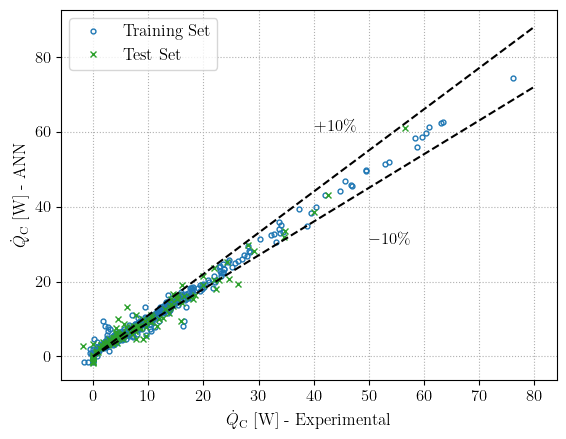

In [38]:
NeuNet(X_train,y_train, 5000, 'Qc [W]')

### Testing the Models

### Reading the Input Parameteres 

In [15]:
Inputs = pd.read_excel('Data/Data_AMR_Exp.xlsx',index_col = 0) # Input Data
X = Inputs[Inputs.columns[:-4]]
y = Inputs[['Qc [W]']]

### Train-Test Split

In [16]:
X = X[(y['Qc [W]'] >= Qc_min) & (X['Tspan [K]'] >= 0)]
y = y[(y['Qc [W]'] >= Qc_min) & (X['Tspan [K]'] >= 0)]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    stratify = X['Test'],
                                                    random_state = 42)
X_train = X_train.drop(['Test'],axis = 1)
X_test = X_test.drop(['Test'],axis = 1)

### Scaling the Features

In [17]:
Scaller = joblib.load('Models/AMR_Scaler.pkl')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 31)               124       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 187)               5984      
                                                                 
 dropout (Dropout)           (None, 187)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 187)              748       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 113)               21244     
                                                                 
 dropout_1 (Dropout)         (None, 113)               0

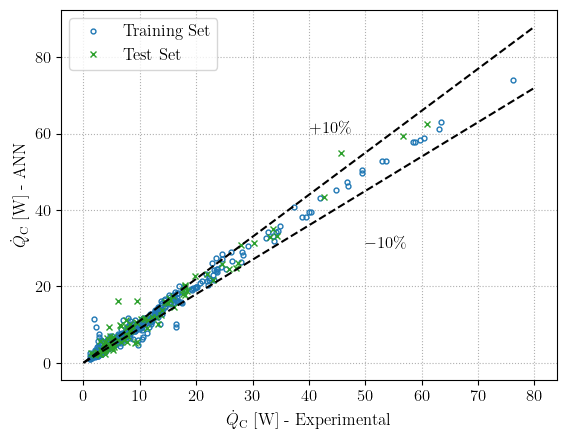

In [20]:
Test(X_train,y_train,'Qc [W]',Scaller)

In [219]:
Obj = 'Qc [W]'

In [122]:
Scal = Scaller

In [164]:
X.columns[0]

'Test'

14/14 [==============================] - 0s 2ms/step


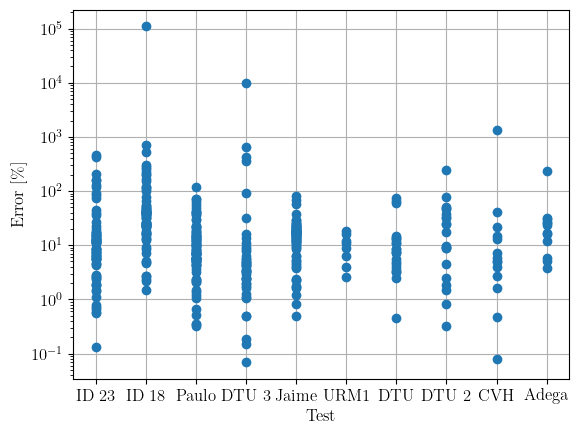

14/14 [==============================] - 0s 2ms/step


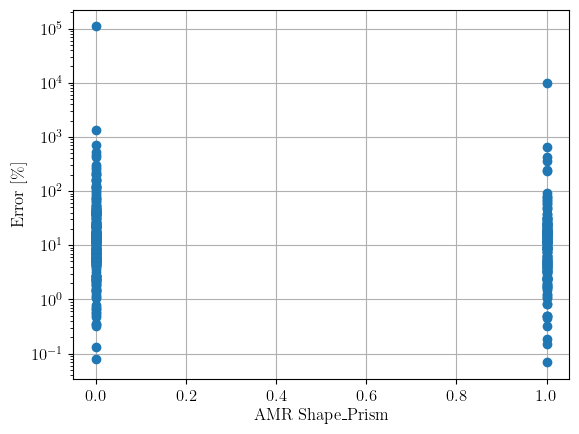

14/14 [==============================] - 0s 2ms/step


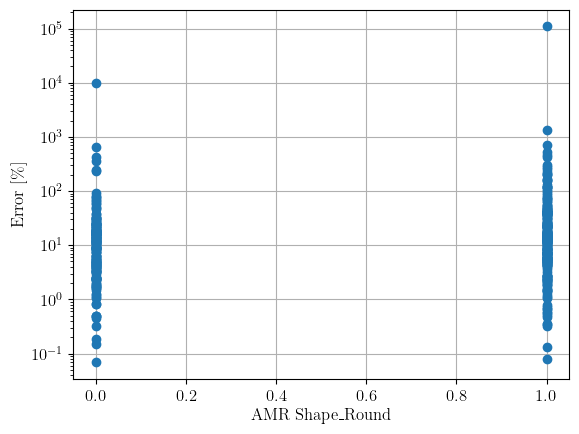

14/14 [==============================] - 0s 2ms/step


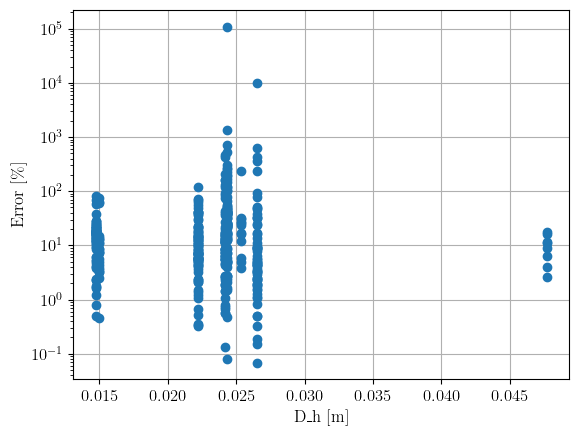

14/14 [==============================] - 0s 2ms/step


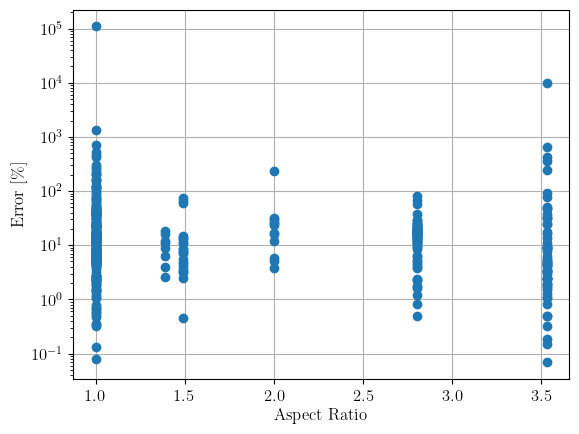

14/14 [==============================] - 0s 2ms/step


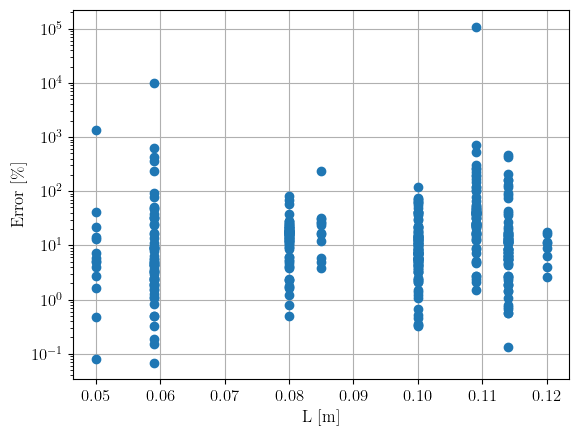

14/14 [==============================] - 0s 2ms/step


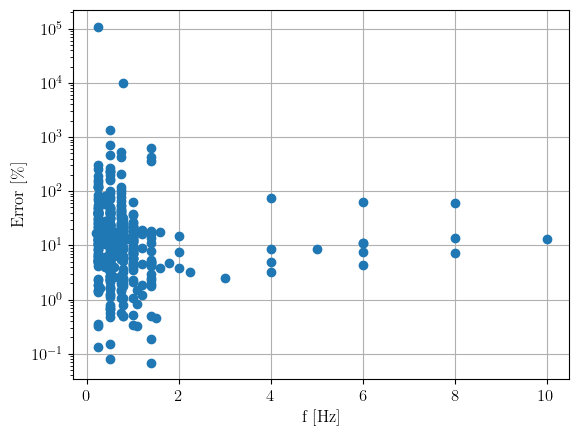

14/14 [==============================] - 0s 2ms/step


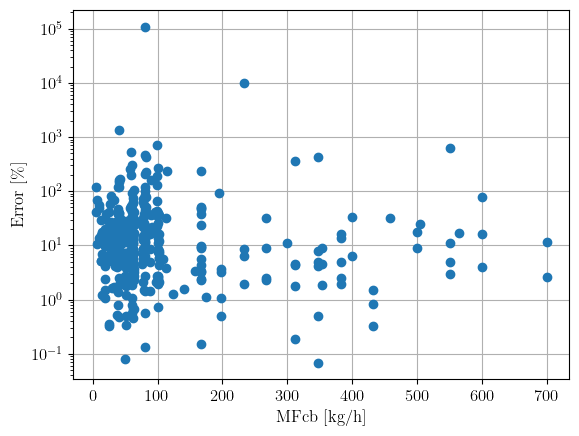

14/14 [==============================] - 0s 2ms/step


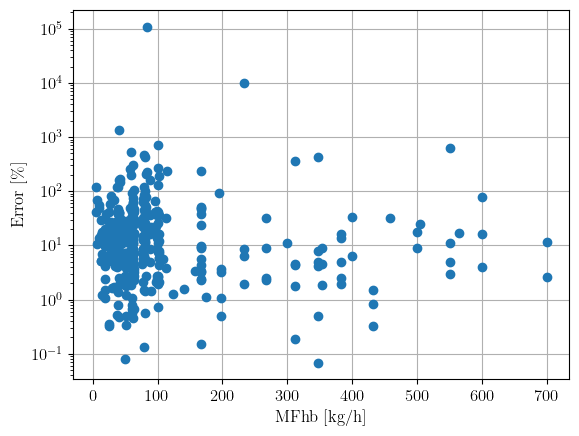

14/14 [==============================] - 0s 2ms/step


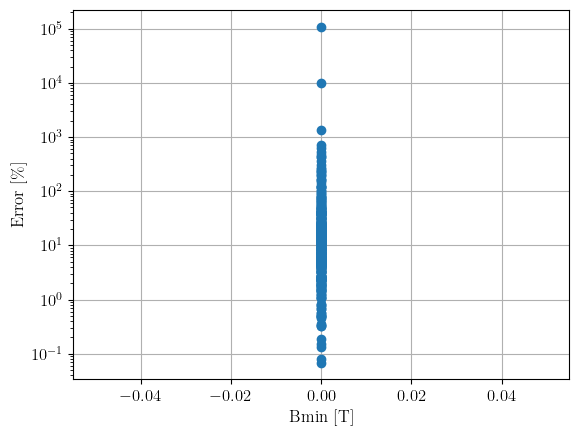

14/14 [==============================] - 0s 2ms/step


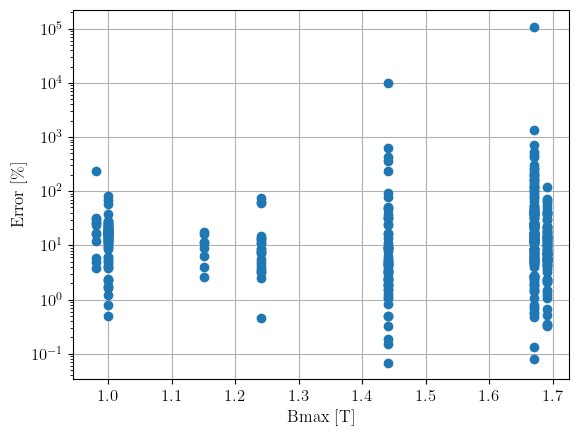

14/14 [==============================] - 0s 2ms/step


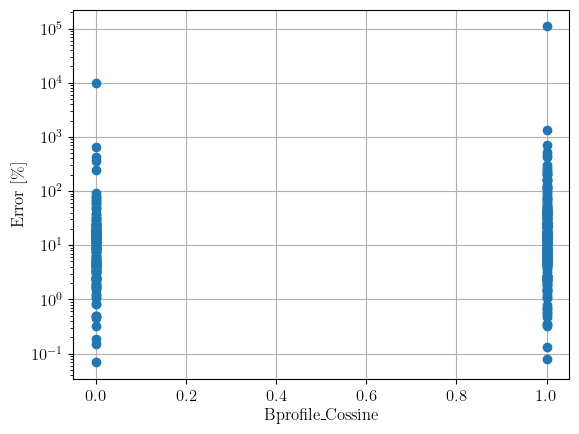

14/14 [==============================] - 0s 2ms/step


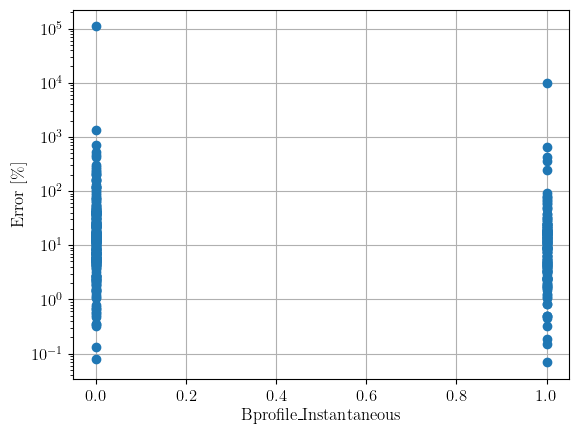

14/14 [==============================] - 0s 2ms/step


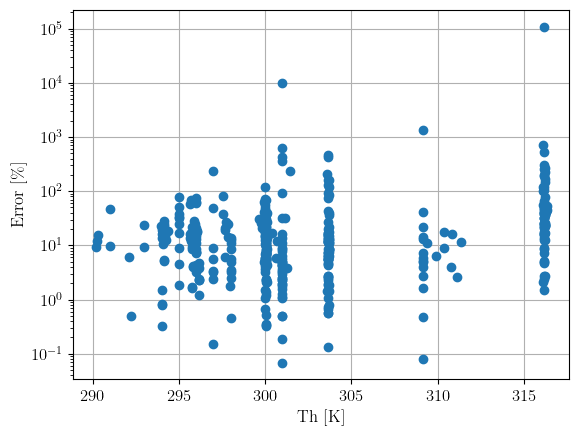

14/14 [==============================] - 0s 2ms/step


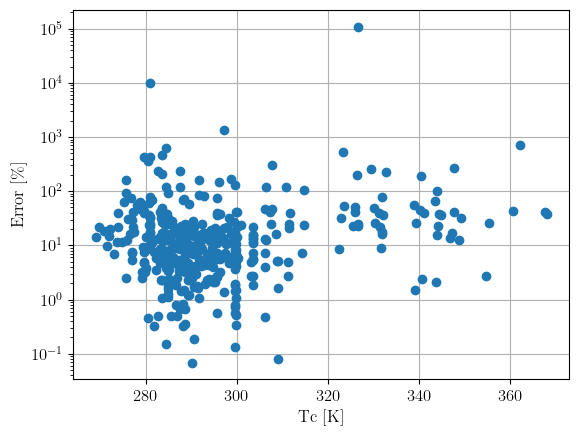

14/14 [==============================] - 0s 2ms/step


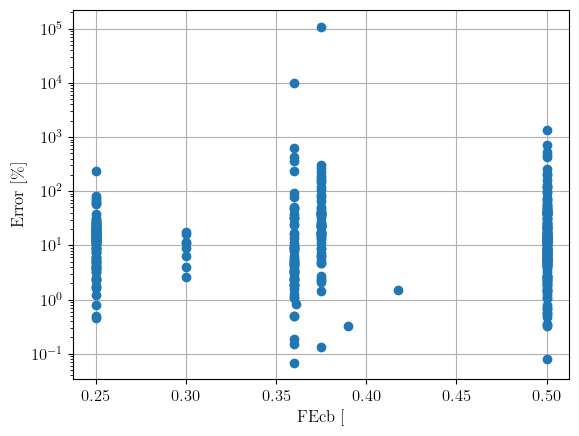

14/14 [==============================] - 0s 2ms/step


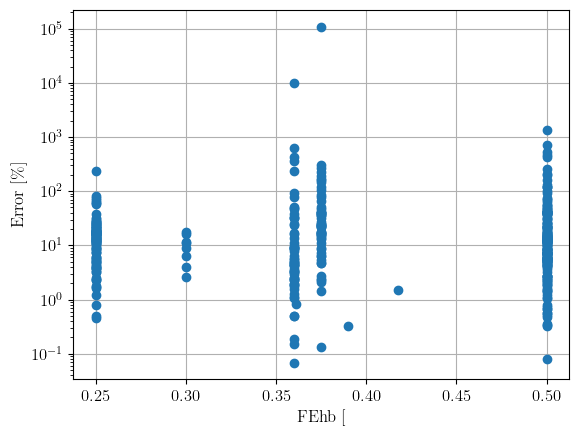

14/14 [==============================] - 0s 2ms/step


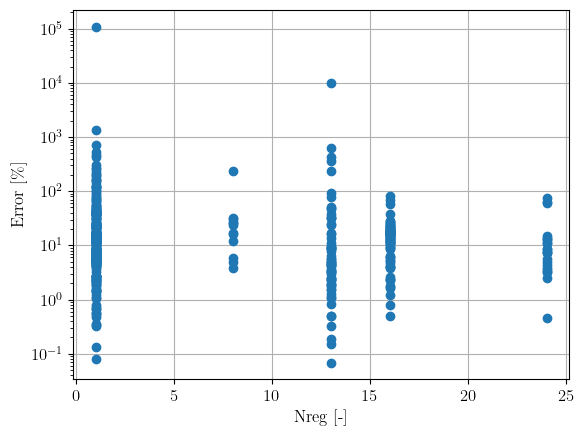

14/14 [==============================] - 0s 2ms/step


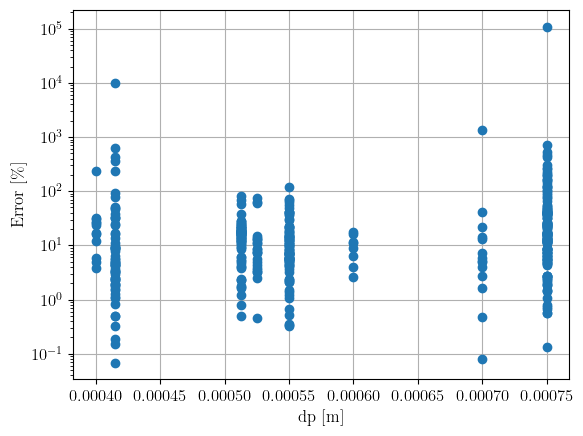

14/14 [==============================] - 0s 2ms/step


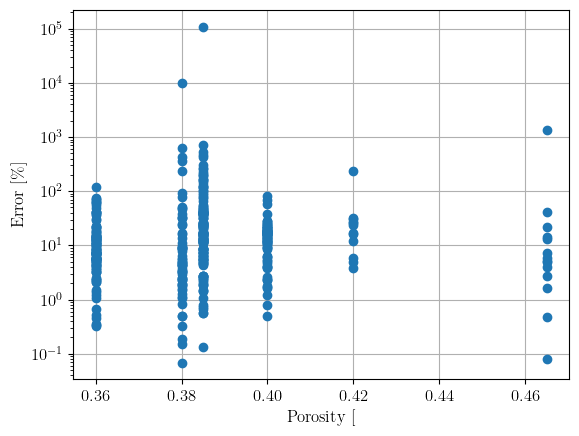

14/14 [==============================] - 0s 2ms/step


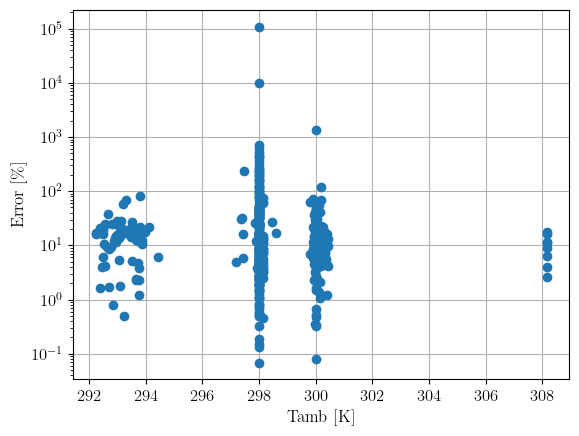

14/14 [==============================] - 0s 2ms/step


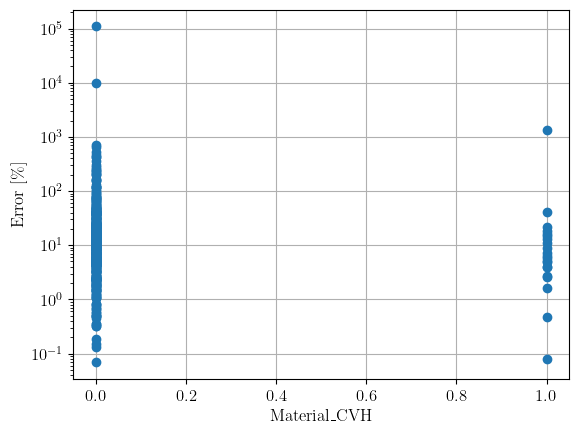

14/14 [==============================] - 0s 2ms/step


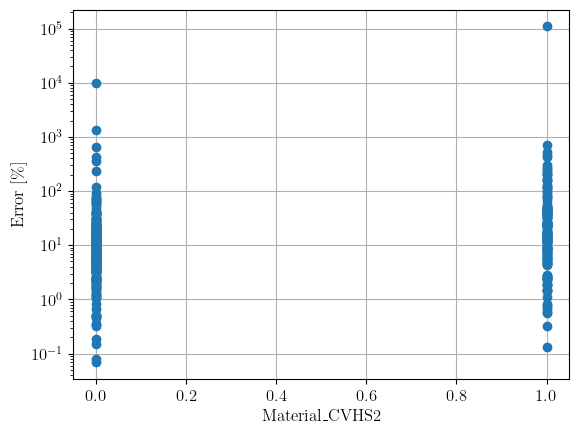

14/14 [==============================] - 0s 2ms/step


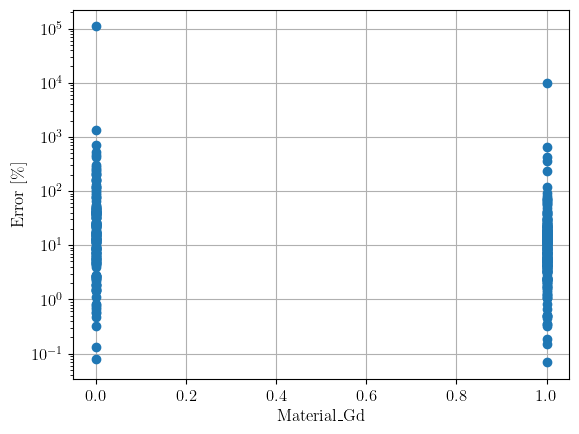

14/14 [==============================] - 0s 2ms/step


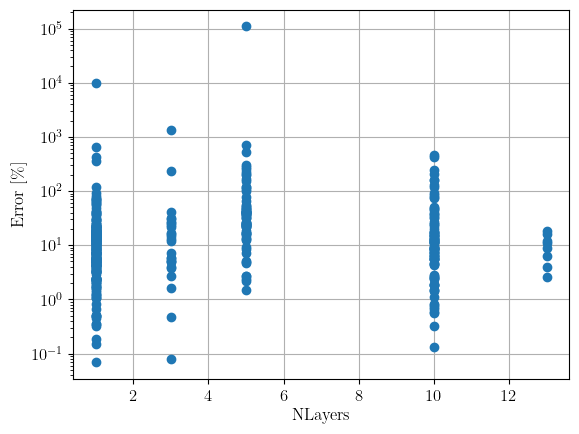

14/14 [==============================] - 0s 2ms/step


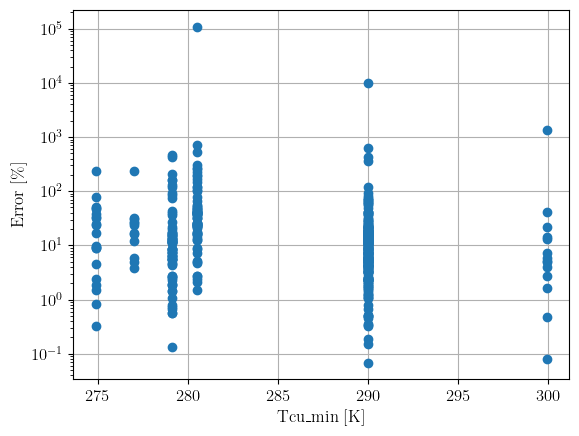

14/14 [==============================] - 0s 2ms/step


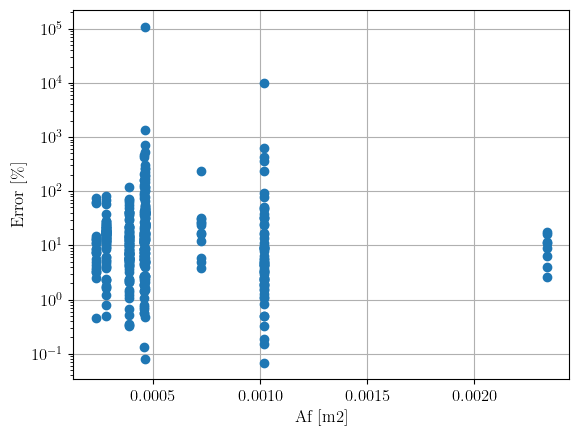

14/14 [==============================] - 0s 2ms/step


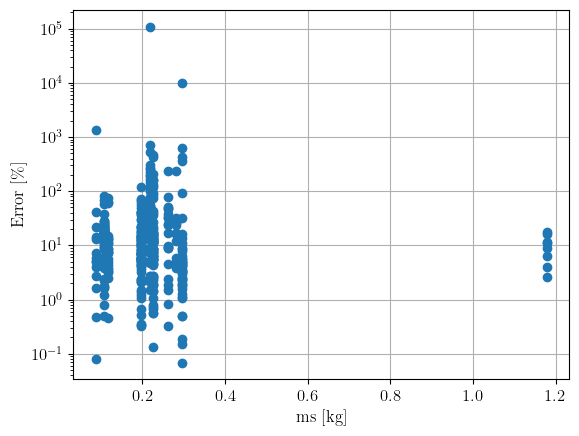

14/14 [==============================] - 0s 2ms/step


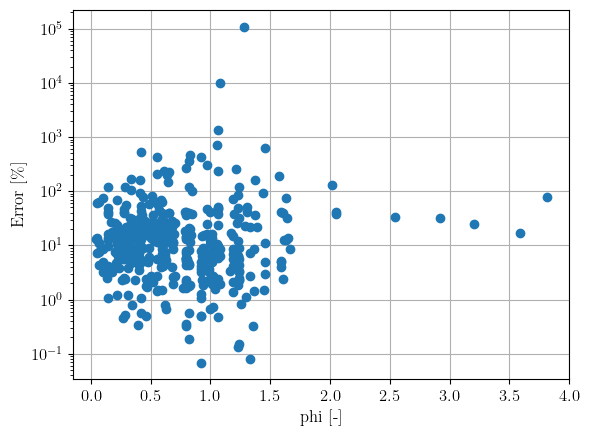

14/14 [==============================] - 0s 2ms/step


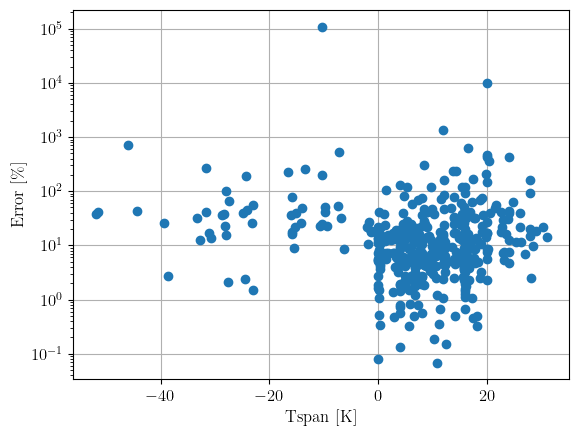

14/14 [==============================] - 0s 2ms/step


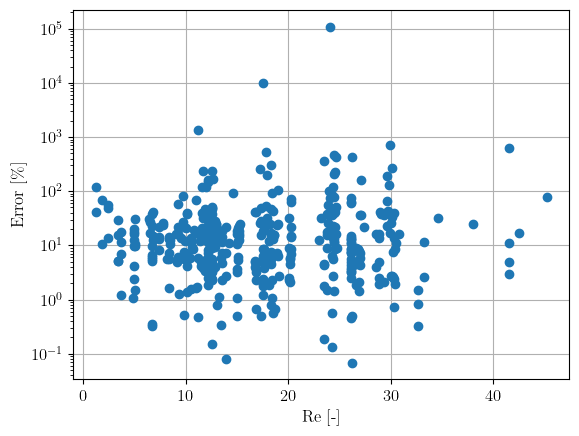

14/14 [==============================] - 0s 2ms/step


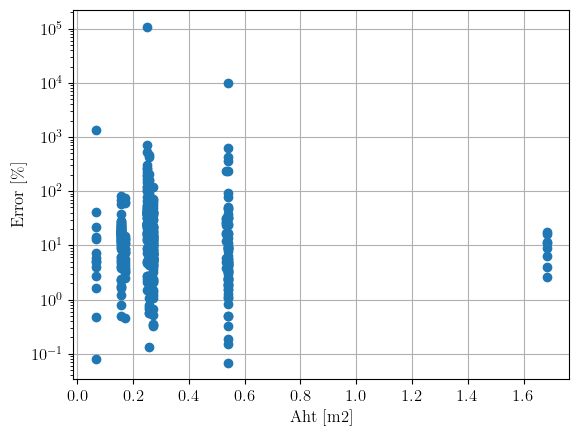

In [176]:
for i in X.columns:
    plt.semilogy(X[i][X_train.index.values],
             (100*abs(y_train[Obj].values - Model.predict(Scal.transform(X_train)).T)/y_train[Obj].values).T, 'o')
    plt.grid()
    plt.ylabel('Error [\%]')
    plt.xlabel(i)
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 31)               124       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 87)                2784      
                                                                 
 dropout (Dropout)           (None, 87)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 87)               348       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 145)               12760     
                                                                 
 dropout_1 (Dropout)         (None, 145)               0

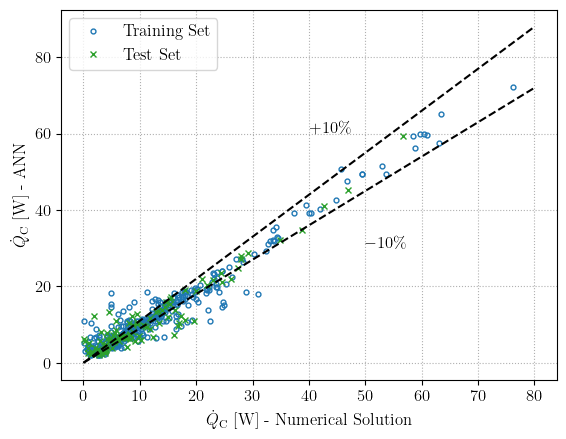

In [127]:
Model = load_model('Models/'+Obj+'/'+ Obj +'_NN.h5', compile = False)
Model.summary()


for i, layer in enumerate (Model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

#R2 for the Training Set
print('The coefficient of determination for '+ Obj +' Training Set using Neural Networks is '+
      str(r2_score(y_train[Obj], Model.predict(Scal.transform(X_train)))))

# R2 for the Test Set
print('The coefficient of determination for '+ Obj +' Test Set using Neural Networks is '+
      str(r2_score(y_test[Obj], Model.predict(Scal.transform(X_test)))))

# Plotting the Results
plot_results(y_train[Obj], Model.predict(Scal.transform(X_train)), y_test[Obj], Model.predict(Scal.transform(X_test)), Obj) 

In [ ]:
Test_lite(X_train,y_train,'Qc [W]',Scaller)